In [24]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import jn, jn_zeros
from IPython.display import Audio

### vibration of membrane

In [3]:
# n_z zeros of Bessel function J0
n_z = 3
mu_n = jn_zeros(0, n_z)

# tension of the membrane [N] T
T = 300.0

# surface density of the membrane [kg/m^2] sigma
sigma = 0.2

# radius of the membrane [m] a
a = 0.33 # 26 inches

# natural frequency of the membrane [Hz] f_n
# f_n = mu_n / (2 * pi * a) * sqrt(T / sigma)
fn = [mu / (2 * np.pi * a) * (T / sigma)**0.5 for mu in mu_n]


### plot the vibration of membrane with different frequency (different modes)

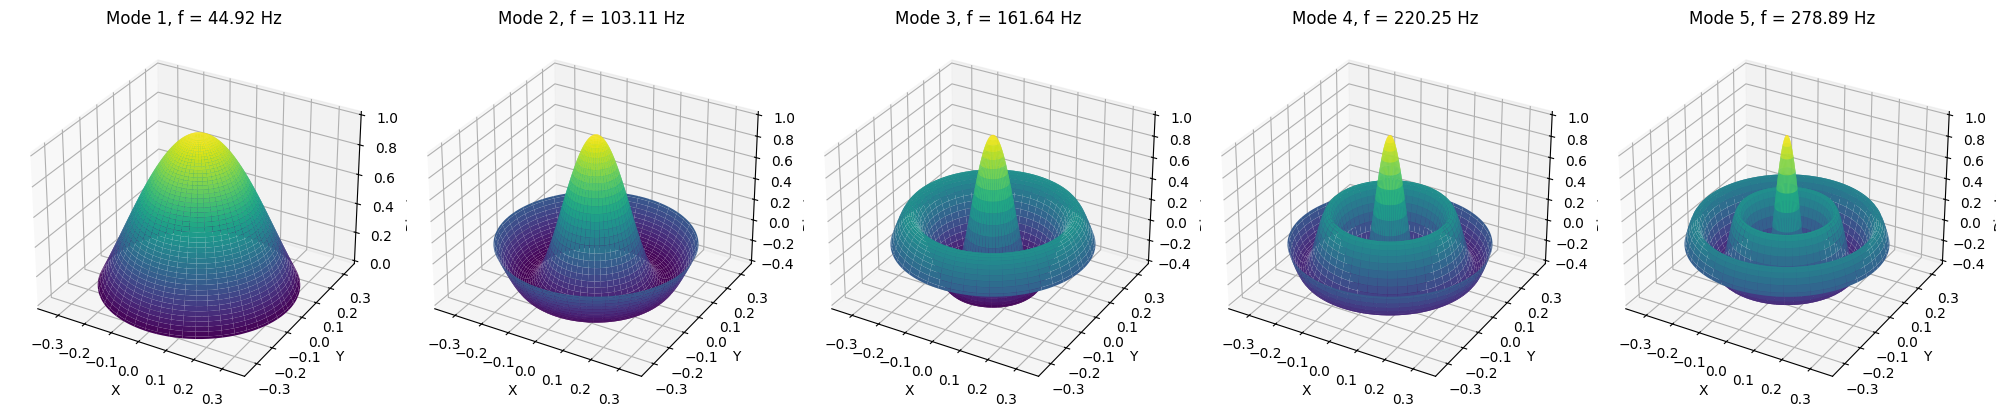

In [10]:
# Create a grid of points
r = np.linspace(0, a, 100)
theta = np.linspace(0, 2 * np.pi, 100)
R, Theta = np.meshgrid(r, theta)

# Calculate the displacement for the first mode
Z = jn(0, mu_n[3] * R / a)

# Convert to Cartesian coordinates for plotting
X = R * np.cos(Theta)
Y = R * np.sin(Theta)

fig, axs = plt.subplots(1, n_z, subplot_kw={'projection': '3d'}, figsize=(20, 4))

for i in range(n_z):
    Z = jn(0, mu_n[i] * R / a)
    axs[i].plot_surface(X, Y, Z, cmap='viridis')
    axs[i].set_title(f'Mode {i+1}, f = {fn[i]:.2f} Hz')
    axs[i].set_xlabel('X')
    axs[i].set_ylabel('Y')
    axs[i].set_zlabel('Displacement')

plt.tight_layout()
plt.show()

### add time term exp(i\omega t) to the solution of the wave equation

In [51]:
omega_n = 2 * np.pi * np.array(fn)

# speed of sound in air [m/s]
c = 343

# density of air [kg/m^3]
rho = 1.225

# postion of the listener
R = 0.5 * a
Theta = np.pi / 2

Fs = 44100
time_duration = 0.3
timebase = np.linspace(0, time_duration, int(Fs * time_duration))

k_n = omega_n / c

p_sum = np.zeros_like(timebase)
alpha_n = [0.4, 0.3, 0.2, 0.1, 0]

# pressure file inside of the timpani
for omega, k, mu, alpha in zip(omega_n, k_n, mu_n, alpha_n):

    # speed of the point on the membrane
    # u_a = [- omega * jn(0, mu * R / a) * np.sin(omega * t) for t in timebase]
    p = [omega * (rho * (- omega * jn(0, mu * R / a) * np.sin(omega * t)) * a**2) / (2 * R) * (2 * jn(1, k * a * np.sin(Theta)) / (k * a * np.sin(Theta))) * np.cos(omega * t - k * R) for t in timebase]
    p_sum += np.array(p) * alpha


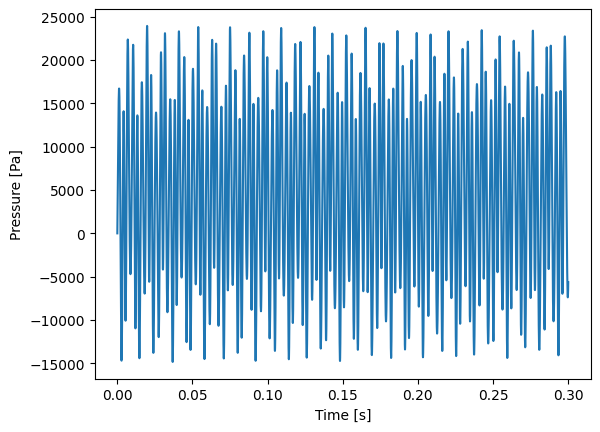

In [52]:
# plot pressure
plt.plot(timebase, p_sum)
plt.xlabel('Time [s]')
plt.ylabel('Pressure [Pa]')
plt.show()

Audio(p_sum, rate=Fs)

### add time delay term on the reflection wave, t = 2 Z/c

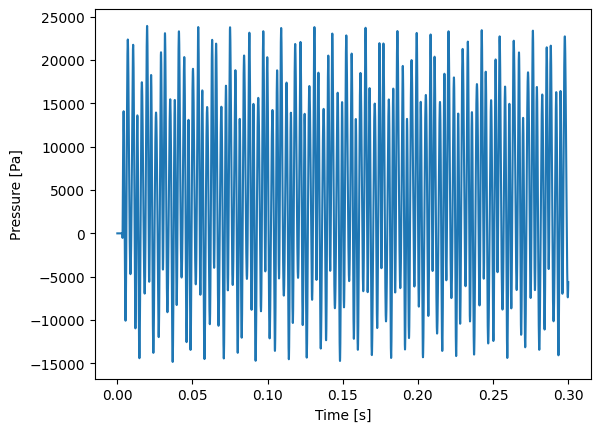

In [53]:
# height of the timpani [m] H
H = 0.8 # 26 inches

# position of the listener
X = R * np.cos(Theta)
Y = R * np.sin(Theta)
Z = -(-H + H / a**2 *(X**2 + Y**2))

time_delay = 2 * Z / c

p_sum_reflected = np.zeros_like(p_sum)
p_sum_reflected[int(time_delay * Fs):] = p_sum[int(time_delay * Fs):]

# plot pressure of reflected sound
plt.plot(timebase, p_sum_reflected)
plt.xlabel('Time [s]')
plt.ylabel('Pressure [Pa]')
plt.show()


### add transmission coeff 

$$
t_I = \frac{4z_1/z_3}{(1+z_1/z_3)^2 \cos^2(k d) + (z_1/z_2 + z_2/z_3)^2 \sin^2(k d)}
$$
$z_1 = z_3$ because these are air, $z_2$ is the impedance of the membrane, $z_2 = \rho c$ where $\rho$ is the density of the membrane and $c$ is the speed of sound in the membrane.

In [55]:
# impedance of air [kg/(m^2 s)]
Z_air = rho * c

# impedance of the membrane [kg/(m^2 s)]
rho_membrane = 800
c_membrane = 1500
Z_membrane = rho_membrane * c_membrane

# thinkness of the membrane [m]
d = 0.001

t_I_n = np.array([(4 / (4 * np.cos(k * d)**2 + (Z_air / Z_membrane + Z_membrane / Z_air)**2 * np.sin(k * d)**2)) for k in k_n])

p_sum_transmitted = np.zeros_like(p_sum)
for omega, k, mu, alpha, t_I in zip(omega_n, k_n, mu_n, alpha_n, t_I_n):
    p = [omega * (rho * (- omega * jn(0, mu * R / a) * np.sin(omega * t)) * a**2) / (2 * R) * (2 * jn(1, k * a * np.sin(Theta)) / (k * a * np.sin(Theta))) * np.cos(omega * t - k * R) for t in timebase]
    p_r = np.zeros_like(p)
    p_r[int(time_delay * Fs):] = p_r[int(time_delay * Fs):]
    p_t = p_r * t_I
    p_sum_transmitted += (np.array(p) + np.array(p_t)) * alpha

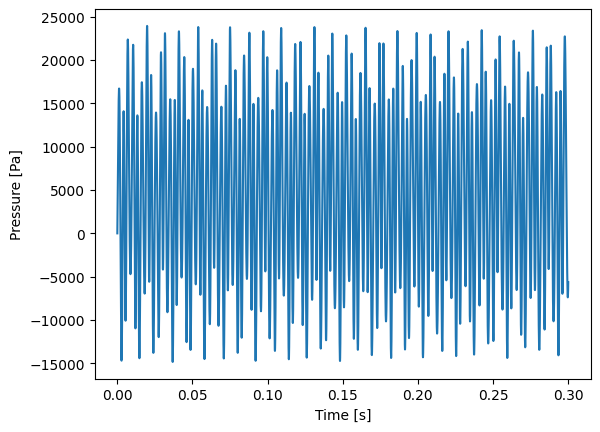

In [56]:
# plot pressure of transmitted sound
plt.plot(timebase, p_sum_transmitted)
plt.xlabel('Time [s]')
plt.ylabel('Pressure [Pa]')
plt.show()
Audio(p_sum_transmitted, rate=Fs)